In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
import random
from typing import Dict, List, Tuple
import numpy as np

class HashDataset(Dataset):
    def __init__(self, tokenizer, num_samples: int = 1000, hash_length: int = 10, chain_length: int = 10, hops: int = 3, vary_hops: bool = False):
        self.tokenizer = tokenizer
        self.data = []
        for _ in range(num_samples):
            hash_map = self.generate_hash_map(chain_length=chain_length, hash_length=hash_length)
            start = list(hash_map.keys())[0]  # Start from the first hash in the chain
            if vary_hops:
                current_hops = random.randint(1, hops)
            else:
                current_hops = hops
            target = self.perform_hash_hop(hash_map, start, current_hops)
            prompt = f"Map:\n"
            # Randomize the order of hash mappings in the prompt
            hash_items = list(hash_map.items())
            random.shuffle(hash_items)
            for key, value in hash_items:
                prompt += f"{key}=>{value}\n"
            prompt += f"Start: {start}\nHops: {current_hops}\nTarget:"
            full_text = f"{prompt} {target}"
            self.data.append((full_text, hash_map, start, current_hops, target, prompt))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        full_text, _, _, _, _, _ = self.data[idx]
        return self.tokenizer.encode(full_text, truncation=True, max_length=512)

    def get_eval_item(self, idx):
        return self.data[idx]

    @staticmethod
    def generate_hash_map(chain_length: int = 10, hash_length: int = 5) -> Dict[str, str]:
        chars = "abcdefghijklmnopqrstuvwxyz0123456789"
        hashes = [''.join(random.choice(chars) for _ in range(hash_length)) for _ in range(chain_length)]
        hash_map = {}
        for i in range(chain_length - 1):
            hash_map[hashes[i]] = hashes[i + 1]
        return hash_map

    @staticmethod
    def perform_hash_hop(hash_map: Dict[str, str], start: str, hops: int) -> str:
        current = start
        for _ in range(hops):
            if current in hash_map:
                current = hash_map[current]
            else:
                break  # Stop if we reach the end of the chain
        return current
        
def collate_fn(batch):
    max_len = max(len(item) for item in batch)
    padded_batch = []
    attention_masks = []
    for item in batch:
        padded_item = item + [0] * (max_len - len(item))
        attention_mask = [1] * len(item) + [0] * (max_len - len(item))
        padded_batch.append(padded_item)
        attention_masks.append(attention_mask)
    return torch.tensor(padded_batch), torch.tensor(attention_masks)



In [2]:
import random
from typing import List, Tuple
from torch.utils.data import Dataset

class ReasoningHashDataset(Dataset):
    def __init__(self, tokenizer, num_samples: int = 1000, hash_length: int = 5, 
                 chains: List[int] = [2, 3, 4, 5, 6], vary_hash: bool = True, num_chains: int = 5):
        self.tokenizer = tokenizer
        self.data = []
        for _ in range(num_samples):
            if vary_hash:
                # Step 1: Sample 1 chain between the smallest and second biggest
                smallest_chain = min(chains)
                second_biggest_chain = sorted(chains)[-2]
                first_chain = random.choice([c for c in chains if smallest_chain <= c <= second_biggest_chain])
                
                # Step 2: Add random chains bigger than the selected chain
                larger_chains = [c for c in chains if c > first_chain]
                if num_chains - 1 <= len(larger_chains):
                    selected_chains = [first_chain] + random.sample(larger_chains, num_chains - 1)
                else:
                    selected_chains = [first_chain] + random.choices(larger_chains, k=num_chains - 1)
            else:
                selected_chains = chains[:num_chains]  # Take the first num_chains elements

            selected_chains.sort()  # Sort to ensure the shortest is first

            hash_list, start, shortest_target = self.generate_hash_list(
                hash_length=hash_length,
                chains=selected_chains
            )
            prompt = f"Map:\n"
            random.shuffle(hash_list)
            for key, value in hash_list:
                prompt += f"{key}=>{value}\n"
            prompt += f"Start: {start}\nTask: shortest path\nTarget:"
            full_text = f"{prompt} {shortest_target}"
            self.data.append((full_text, hash_list, start, shortest_target, prompt))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        full_text, _, _, _, _ = self.data[idx]
        return self.tokenizer.encode(full_text, truncation=True, max_length=512)

    def get_eval_item(self, idx):
        return self.data[idx]

    @staticmethod
    def generate_hash_list(hash_length: int, chains: List[int]) -> Tuple[List[Tuple[str, str]], str, str]:
        chars = "abcdefghijklmnopqrstuvwxyz0123456789"
        hash_list = []
        
        # Generate start hash
        start = ''.join(random.choice(chars) for _ in range(hash_length))
        
        shortest_length = min(chains)
        shortest_target = None
        
        # Generate chains
        for chain_length in chains:
            current = start
            for _ in range(chain_length - 1):  # -1 because start is already counted
                next_hash = ''.join(random.choice(chars) for _ in range(hash_length))
                hash_list.append((current, next_hash))
                current = next_hash
            
            if chain_length == shortest_length:
                shortest_target = current
        
        return hash_list, start, shortest_target

    @staticmethod
    def find_shortest_path(hash_list: List[Tuple[str, str]], start: str) -> int:
        graph = {}
        for src, dest in hash_list:
            if src not in graph:
                graph[src] = []
            graph[src].append(dest)

        visited = set()
        queue = [(start, 0)]
        
        while queue:
            current, length = queue.pop(0)
            if current not in graph:
                return length  # Return the length of the path
            
            if current not in visited:
                visited.add(current)
                for next_hash in graph[current]:
                    queue.append((next_hash, length + 1))
        
        return -1  # This should never happen if the hash list is correctly generated

In [3]:
# Create an instance of ReasoningHashDataset
dataset = ReasoningHashDataset(None, num_samples=1, hash_length=3, chains=[2, 3])

# Get the first sample from the dataset
full_text, hash_list, start, shortest_target, prompt = dataset.get_eval_item(0)

print(full_text)


Map:
2xq=>49l
2xq=>fh2
49l=>gag
k88=>gpr
2xq=>k88
2xq=>qny
qny=>xng
8fg=>g5l
2xq=>8fg
Start: 2xq
Task: shortest path
Target: fh2


In [3]:
# # Import necessary libraries
# import random
# from transformers import AutoTokenizer
# from torch.utils.data import Dataset

# chains = [2, 3]

# # Create an instance of ReasoningHashDataset
# dataset = ReasoningHashDataset(None, num_samples=5, hash_length=3, chains=chains)

# # Function to visualize the hash list and verify chain lengths
# def visualize_and_verify_hash_list(hash_list, start, target):
#     print("Hash List:")
#     for src, dest in hash_list:
#         print(f"{src} => {dest}")
#     print(f"Start: {start}")
#     print(f"Shortest path target: {target}")
#     print("Paths and their lengths:")
    
#     def dfs(current, path, visited):
#         if current not in [src for src, _ in hash_list]:
#             print(f"{' => '.join(path)} (length: {len(path)})")
#             return
#         for src, dest in hash_list:
#             if src == current and dest not in visited:
#                 dfs(dest, path + [dest], visited | {dest})
    
#     dfs(start, [start], {start})

# # Test the dataset
# for i in range(5):  # Display 5 samples
#     print(f"\nSample {i+1}:")
#     full_text, hash_list, start, shortest_target, prompt = dataset.get_eval_item(i)
    
#     print(full_text)
#     # print("Visualization and Verification:")
#     # visualize_and_verify_hash_list(hash_list, start, shortest_target)
    
#     # # Verify the shortest path
#     # computed_shortest = dataset.find_shortest_path(hash_list, start)
#     # print(f"\nComputed shortest path target: {computed_shortest}")
#     # print(f"Matches dataset target: {computed_shortest == shortest_target}")
#     # print("-" * 50)

# # Additional verification
# print("\nVerifying chain lengths:")
# _, hash_list, start, _, _ = dataset.get_eval_item(0)
# chain_lengths = []
# graph = {}
# for src, dest in hash_list:
#     if src not in graph:
#         graph[src] = []
#     graph[src].append(dest)

# def count_chain_length(node, length):
#     if node not in graph:
#         chain_lengths.append(length)
#         return
#     for next_node in graph[node]:
#         count_chain_length(next_node, length + 1)

# count_chain_length(start, 1)

# print(f"Generated chain lengths: {sorted(chain_lengths)}")

# # Verify multiple paths from start
# start_paths = [dest for src, dest in hash_list if src == start]
# print(f"\nNumber of paths from start: {len(start_paths)}")
# print(f"Unique paths from start: {len(set(start_paths))}")
# print(f"Correct number of paths: {len(start_paths) == len(chains)}")

In [6]:
from torch import nn

def set_lora_parameters_trainable(model):
    for name, param in model.named_parameters():
        if "lora" in name.lower():
            param.requires_grad = True
            print(f"LoRA parameter: {name}, size: {param.shape}")
        else:
            param.requires_grad = False

# Function to add LoRA to a linear layer and replace the original layer
def add_lora_to_linear_and_replace(layer, rank=8, alpha=4):
    in_features, out_features = layer.nx, layer.nf
    
    # Get the dtype of the original layer
    dtype = layer.weight.dtype

    # LoRA Layer with correct input-output dimensions and matching dtype
    lora_layer = LoRALayer(in_features, out_features, rank=rank, alpha=alpha, dtype=dtype)

    # Combine the original layer and LoRA layer
    class CombinedLayer(nn.Module):
        def __init__(self, base_layer, lora_layer):
            super().__init__()
            self.base_layer = base_layer
            self.lora_layer = lora_layer

        def forward(self, x):
            return self.base_layer(x) + self.lora_layer(x)

    combined_layer = CombinedLayer(layer, lora_layer)
    # Ensure the combined layer is on the same device as the original layer
    combined_layer = combined_layer.to(layer.weight.device)
    return combined_layer

# Custom LoRA layer with proper dimension handling
class LoRALayer(nn.Module):
    def __init__(self, in_features, out_features, rank=8, alpha=4, dtype=torch.float16):
        super().__init__()
        # Initialize parameters with the specified dtype
        self.lora_A = nn.Parameter(torch.randn(in_features, rank, dtype=dtype) / rank)
        self.lora_B = nn.Parameter(torch.zeros(rank, out_features, dtype=dtype) / rank)
        self.scaling = alpha / rank

    def forward(self, x):
        # Ensure input tensor is the same dtype as LoRA parameters
        if x.dtype != self.lora_A.dtype:
            x = x.to(self.lora_A.dtype)
        return (x @ self.lora_A @ self.lora_B) * self.scaling


# Apply LoRA to the last N layers by replacing the original ones
def replace_with_lora_layers_last_n(model, n_layers_to_modify=10, rank=8, alpha=4):
    count = 0
    for name, module in reversed(list(model.named_modules())):
        if any(x in name for x in ["mlp.c_proj"]): # ['attn.c_attn', 'attn.c_proj'] ["mlp.c_proj"]
            parent_name = name.rsplit(".", 1)[0]
            parent_module = model.get_submodule(parent_name) if parent_name else model
            child_name = name.split(".")[-1]

            layer_type = "Attention" if "attn" in name else "FFN"
            print(f"Replacing {child_name} ({layer_type}) in {parent_name} with LoRA-enhanced layer")
            setattr(parent_module, child_name, add_lora_to_linear_and_replace(module, rank=rank, alpha=alpha))

            count += 1
            if count >= n_layers_to_modify:
                break

    return model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [4]:
USE_LORA = False

if USE_LORA:
    # Apply the layer replacement to the last N layers in the base model
    replace_with_lora_layers_last_n(model, n_layers_to_modify=6)

    # Call the function at the end
    set_lora_parameters_trainable(model)

lora_params = [p for n, p in model.named_parameters() if "lora" in n.lower()]

In [4]:
import torch.nn.functional as F

hash_length = 5
hidden_size = 64
batch_size = 32
num_epochs = 10

train_dataset = ReasoningHashDataset(tokenizer, num_samples=10000, chains=[3,3,2])
val_dataset = ReasoningHashDataset(tokenizer, num_samples=1000, chains=[3,3,2])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(lora_params if USE_LORA else model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

train_losses = []
val_losses = []

def compute_loss(logits, labels, attention_mask):
    # Only consider the last 4 tokens for loss computation
    last_4_logits = logits[:, -4:, :].contiguous()
    last_4_labels = labels[:, -4:].contiguous()
    last_4_mask = attention_mask[:, -4:].contiguous()
    
    # Reshape logits and labels for loss computation
    last_4_logits = last_4_logits.view(-1, last_4_logits.size(-1))
    last_4_labels = last_4_labels.view(-1)
    last_4_mask = last_4_mask.view(-1)
    
    # Compute loss only on non-padded tokens
    loss = F.cross_entropy(last_4_logits, last_4_labels, reduction='none')
    loss = (loss * last_4_mask).sum() / last_4_mask.sum()
    
    return loss

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (batch, attention_masks) in enumerate(train_loader):
        batch, attention_masks = batch.to(device), attention_masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch, attention_mask=attention_masks)
        logits = outputs.logits
        
        loss = compute_loss(logits, batch, attention_masks)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
        
        # Interbatch logging
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}")
            print(f"Train Loss: {train_loss/(batch_idx+1):.4f}")
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (batch, attention_masks) in enumerate(val_loader):
            batch, attention_masks = batch.to(device), attention_masks.to(device)
            outputs = model(batch, attention_mask=attention_masks)
            logits = outputs.logits
            loss = compute_loss(logits, batch, attention_masks)
            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"\nEpoch {epoch+1}/{num_epochs} Summary")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}")
    print()

NameError: name 'tokenizer' is not defined

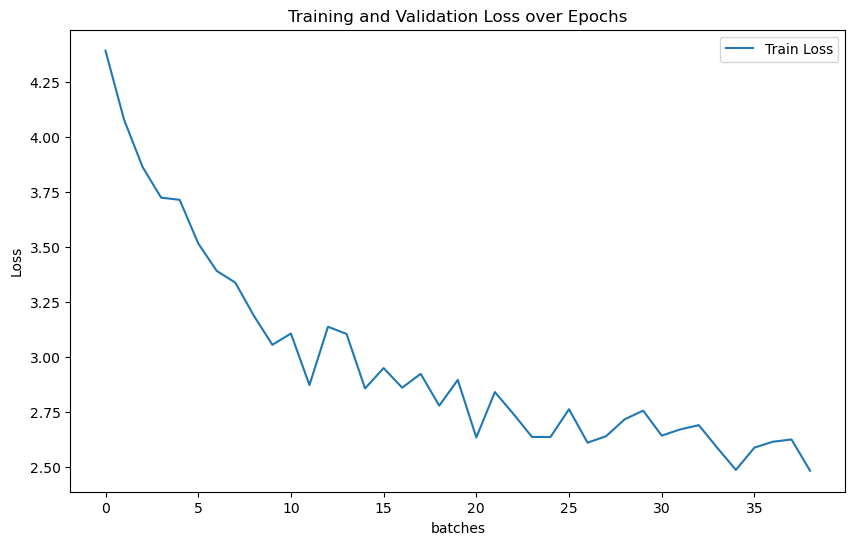

In [5]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
#plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('batches')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [7]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json

def generate_hash(model, tokenizer, prompt, max_length=20):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long).to(model.device)
    pad_token_id = tokenizer.eos_token_id
    
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.01,
        pad_token_id=pad_token_id
    )
    
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text.split("Target:")[-1].strip()[:10]

def evaluate_hash_hop(model, tokenizer, num_tests: int = 100, hash_length: int = 4, vary_hops: bool = False, chain_length: int = 10, hops: int = 1):
    model.eval()
    
    # Create evaluation dataset
    eval_dataset = HashDataset(tokenizer, num_samples=num_tests, hops=hops, vary_hops=vary_hops, hash_length=hash_length, chain_length=chain_length)
    
    correct_predictions = 0
    total_predictions = 0

    for _ in tqdm(range(len(eval_dataset)), desc=f"Evaluating {hops} hop(s)", leave=False):
        full_text, hash_map, start, current_hops, actual_target, prompt = eval_dataset.get_eval_item(_)
        predicted_target = generate_hash(model, tokenizer, prompt)
  
        predicted_target = predicted_target[:hash_length].lower()
        actual_target = actual_target[:hash_length].lower()

        total_predictions += 1
        if any(predicted_target[i:i+3] == actual_target[i:i+3] for i in range(len(predicted_target)-2)):
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

def evaluate_reasoning_hash(model, tokenizer, num_tests: int = 100, hash_length: int = 5, 
                            chains: List[int] = [3, 4, 5, 6], vary_hash: bool = True, num_chains: int = 4):
    model.eval()
    
    # Create evaluation dataset
    eval_dataset = ReasoningHashDataset(tokenizer, num_samples=num_tests, hash_length=hash_length, 
                                        chains=chains, vary_hash=vary_hash, num_chains=num_chains)
    
    correct_predictions = 0
    total_predictions = 0
    chain_accuracies = {}

    for _ in tqdm(range(len(eval_dataset)), desc="Evaluating Reasoning Hash", leave=False):
        full_text, hash_list, start, actual_target, prompt = eval_dataset.get_eval_item(_)
        predicted_target = generate_hash(model, tokenizer, prompt)

        predicted_target = predicted_target[:3].lower()
        actual_target = actual_target[:3].lower()

        total_predictions += 1
        if any(predicted_target[i:i+3] == actual_target[i:i+3] for i in range(len(predicted_target)-2)):
            correct_predictions += 1
        
        # Determine the chain length for this sample
        chain_length = ReasoningHashDataset.find_shortest_path(hash_list, start) + 1
        
        # Initialize the chain_length entry if it doesn't exist
        if chain_length not in chain_accuracies:
            chain_accuracies[chain_length] = {'correct': 0, 'total': 0}
        
        chain_accuracies[chain_length]['total'] += 1
        if predicted_target == actual_target:
            chain_accuracies[chain_length]['correct'] += 1

    overall_accuracy = correct_predictions / total_predictions
    for length in chain_accuracies:
        if chain_accuracies[length]['total'] > 0:
            chain_accuracies[length]['accuracy'] = chain_accuracies[length]['correct'] / chain_accuracies[length]['total']
        else:
            chain_accuracies[length]['accuracy'] = 0

    return overall_accuracy, chain_accuracies

def visualize_reasoning_hash_performance(model, tokenizer, num_tests: int = 100, hash_length: int = 5, 
                                         chains: List[int] = [3, 4, 5, 6], vary_hash: bool = False, num_chains: int = 4):
    model_path = model.model_path
    log_file = f"{model_path}_reasoning.log"
    
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            cached_results = json.load(f)
        
        if (cached_results['num_tests'] == num_tests and
            cached_results['hash_length'] == hash_length and
            cached_results['chains'] == chains and
            cached_results['vary_hash'] == vary_hash and
            cached_results['num_chains'] == num_chains):
            
            print(f"Loading cached results from {log_file}")
            overall_accuracy = cached_results['overall_accuracy']
            chain_accuracies = cached_results['chain_accuracies']
            chain_accuracies = {int(k): v for k, v in chain_accuracies.items()}
        else:
            print("Cached results don't match current parameters. Running new tests.")
            overall_accuracy, chain_accuracies = None, None
    else:
        overall_accuracy, chain_accuracies = None, None
    
    if overall_accuracy is None or chain_accuracies is None:
        overall_accuracy, chain_accuracies = evaluate_reasoning_hash(model, tokenizer, num_tests, hash_length, 
                                                                     chains, vary_hash, num_chains)
        
        results = {
            'num_tests': num_tests,
            'hash_length': hash_length,
            'chains': chains,
            'vary_hash': vary_hash,
            'num_chains': num_chains,
            'overall_accuracy': overall_accuracy,
            'chain_accuracies': {int(k): v for k, v in chain_accuracies.items()}
        }
        with open(log_file, 'w') as f:
            json.dump(results, f)
        print(f"Results cached to {log_file}")
    
    print(f"Chain accuracies: {chain_accuracies}")
    print(f"Chains: {chains}")
    print(f"Overall accuracy: {overall_accuracy}")

    # Process the data for plotting
    chain_lengths = sorted(int(k) for k in chain_accuracies.keys())
    accuracies = [chain_accuracies[length]['accuracy'] for length in chain_lengths]
    # Create the bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(chain_lengths, accuracies, align='center', alpha=0.8)
    plt.title('Chain Length vs Accuracy')
    plt.xlabel('Chain Length')
    plt.ylabel('Accuracy')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add overall accuracy as a horizontal line
    plt.axhline(y=overall_accuracy, color='r', linestyle='--', label=f'Overall Accuracy: {overall_accuracy:.2f}%')

    # Set y-axis limits from 0 to 100
    plt.ylim(0, 1)

    # Customize x-axis
    plt.xticks(chain_lengths)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    plt.legend()
    plt.tight_layout()

    # Save the plot
    plot_file = f"{model_path}_reasoning_plot_bar.png"
    plt.savefig(plot_file)
    print(f"Plot saved to {plot_file}")

    # Show the plot
    plt.show()

    
def compare_hop_performance(model, tokenizer, num_tests: int = 40, hash_length: int = 4, chain_length: int = 10, hops = 4):
    hop_counts = list(range(1, hops + 1))
    accuracies = []
    
    # Construct the log file path
    model_path = model.model_path
    log_file = f"{model_path}.log"
    print(log_file)
    
    # Check if log file exists
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            cached_results = json.load(f)
        
        # Check if cached results match current parameters
        if (cached_results['num_tests'] == num_tests and
            cached_results['hash_length'] == hash_length and
            cached_results['chain_length'] == chain_length and
            cached_results['hops'] == hops):
            
            print(f"Loading cached results from {log_file}")
            accuracies = cached_results['accuracies']
        else:
            print("Cached results don't match current parameters. Running new tests.")
    
    # If no valid cached results, run the tests
    if not accuracies:
        for hops in tqdm(hop_counts, desc="Evaluating hop counts"):
            accuracy = evaluate_hash_hop(model, tokenizer, num_tests=num_tests, hash_length=hash_length, vary_hops=False, chain_length=chain_length, hops=hops)
            accuracies.append(accuracy)
            print(f"Accuracy for {hops} hop(s): {accuracy:.2f}")
        
        # Cache the results
        results = {
            'num_tests': num_tests,
            'hash_length': hash_length,
            'chain_length': chain_length,
            'hops': hops,
            'accuracies': accuracies
        }
        with open(log_file, 'w') as f:
            json.dump(results, f)
        print(f"Results cached to {log_file}")
    
    # Plotting code remains the same
    plt.figure(figsize=(10, 6))
    plt.plot(hop_counts, accuracies, marker='o', label='Model Accuracy')
    
    random_guess_accuracy = 1 / chain_length
    plt.axhline(y=random_guess_accuracy, color='r', linestyle='--', label=f'Random Guess ({random_guess_accuracy:.3f})')
    
    plt.title(f"{model_path} Performance vs Number of Hops\n(Hash Length: {hash_length}, Chain Length: {chain_length})")
    plt.xlabel("Number of Hops")
    plt.ylabel("Accuracy")
    plt.ylim(0, max(max(accuracies), random_guess_accuracy) * 1.1)
    plt.xticks(hop_counts)
    plt.grid(True)
    plt.legend()
    plt.show()

# Load the trained model
model_path = "output_lora_r256_a128_hops1-6/model_epoch_40.pt"
model_name = "gpt2"

# Load the pre-trained GPT-2 model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the state dict from the saved model
state_dict = torch.load(model_path)

replace_with_lora_layers_last_n(model, n_layers_to_modify=12, rank=256, alpha=128)

# Load the state dict into the model
model.load_state_dict(state_dict)

model.model_path = model_path

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

print(f"Loaded model from {model_path}")

Replacing c_proj (FFN) in transformer.h.11.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.10.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.9.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.8.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.7.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.6.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.5.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.4.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.3.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.2.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.1.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.0.mlp with LoRA-enhanced layer
Loaded model from output_lora_r256_a128_hops1-6/model_epoch_40.pt


In [ ]:
import re
m = ["output_lora_r256_a128_hops1-6/model_epoch_40.pt", "output_lora_r128_a64_hops1-6/model_epoch_40.pt", "output_lora_r64_a32_hops1-6/model_epoch_40.pt", "output_lora_r32_a16_hops1-6/model_epoch_40.pt", "output_lora_r16_a8_hops1-6/model_epoch_40.pt"]


def extract_rank_alpha(model_path):
    # Using regex to extract rank and alpha values
    # Matches patterns like "r128_a64" or "r32_a16"
    match = re.search(r'r(\d+)_a(\d+)', model_path)
    if match:
        rank = int(match.group(1))
        alpha = int(match.group(2))
        return rank, alpha
    raise ValueError(f"Could not extract rank and alpha from path: {model_path}")


for i in m:
    # Load the trained model
    model_path = i
    model_name = "gpt2"

    # Load the pre-trained GPT-2 model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Load the state dict from the saved model
    state_dict = torch.load(model_path)

    rank, alpha = extract_rank_alpha(i)
    replace_with_lora_layers_last_n(model, n_layers_to_modify=12, rank=rank, alpha=alpha)

    # Load the state dict into the model
    model.load_state_dict(state_dict)

    model.model_path = model_path

    # Move the model to the appropriate device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    print(f"Loaded model from {model_path}")
    visualize_reasoning_hash_performance(model, tokenizer, num_tests=1000, hash_length=3, chains=[8,7,6,5,4,3,2], vary_hash=True, num_chains=4)

Replacing c_proj (FFN) in transformer.h.11.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.10.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.9.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.8.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.7.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.6.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.5.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.4.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.3.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.2.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.1.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.0.mlp with LoRA-enhanced layer
Loaded model from output_lora_r128_a64_hops1-6/model_epoch_40.pt
Loading cached results from output_lora_r128_a64_hops1-6/model_epoch_40.pt_reason

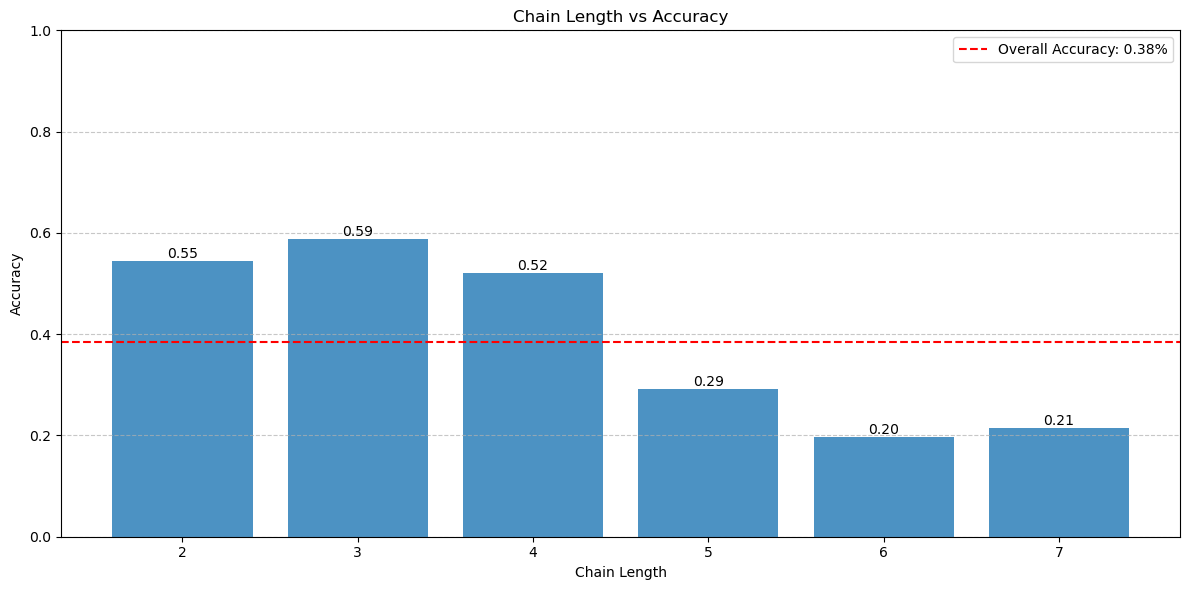

Replacing c_proj (FFN) in transformer.h.11.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.10.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.9.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.8.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.7.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.6.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.5.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.4.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.3.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.2.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.1.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.0.mlp with LoRA-enhanced layer
Loaded model from output_lora_r64_a32_hops1-6/model_epoch_40.pt
Loading cached results from output_lora_r64_a32_hops1-6/model_epoch_40.pt_reasonin

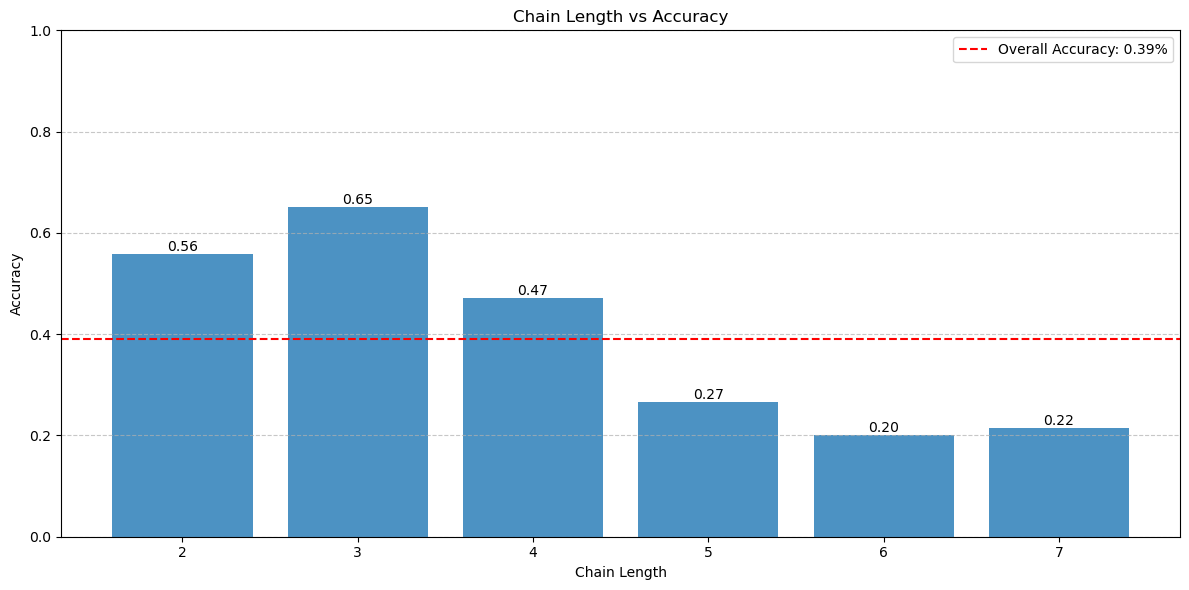

Replacing c_proj (FFN) in transformer.h.11.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.10.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.9.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.8.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.7.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.6.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.5.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.4.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.3.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.2.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.1.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.0.mlp with LoRA-enhanced layer
Loaded model from output_lora_r32_a16_hops1-6/model_epoch_40.pt
Loading cached results from output_lora_r32_a16_hops1-6/model_epoch_40.pt_reasonin

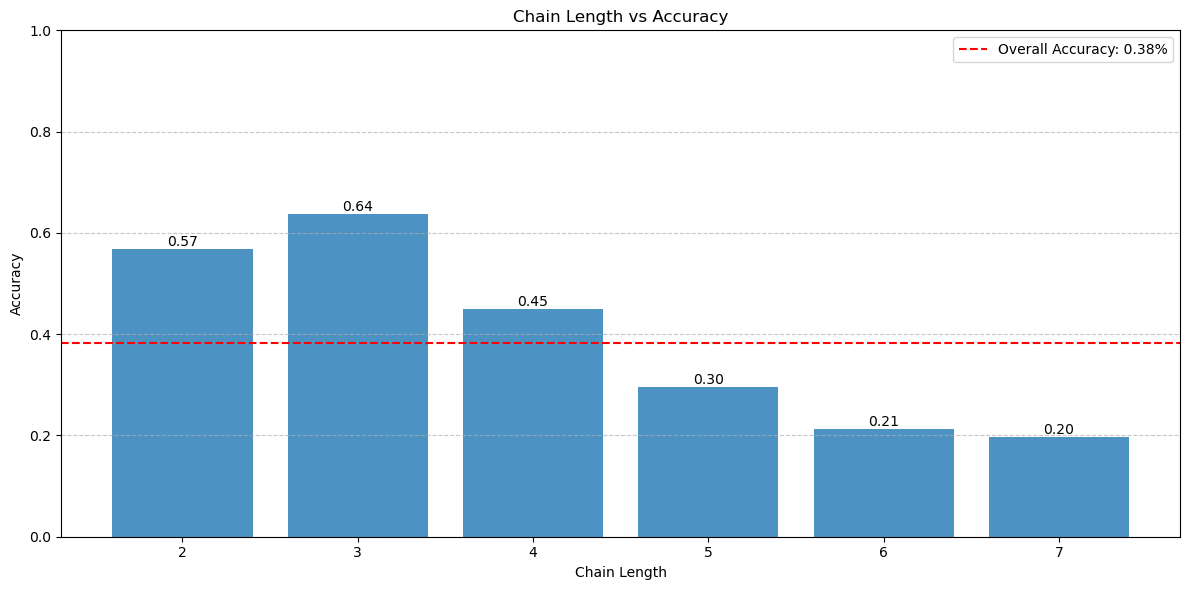

Replacing c_proj (FFN) in transformer.h.11.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.10.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.9.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.8.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.7.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.6.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.5.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.4.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.3.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.2.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.1.mlp with LoRA-enhanced layer
Replacing c_proj (FFN) in transformer.h.0.mlp with LoRA-enhanced layer
Loaded model from output_lora_r16_a8_hops1-6/model_epoch_40.pt


Results cached to output_lora_r16_a8_hops1-6/model_epoch_40.pt_reasoning.log
Chain accuracies: {3: {'correct': 106, 'total': 168, 'accuracy': 0.6309523809523809}, 6: {'correct': 49, 'total': 169, 'accuracy': 0.28994082840236685}, 4: {'correct': 65, 'total': 141, 'accuracy': 0.46099290780141844}, 5: {'correct': 39, 'total': 179, 'accuracy': 0.21787709497206703}, 2: {'correct': 109, 'total': 182, 'accuracy': 0.5989010989010989}, 7: {'correct': 34, 'total': 161, 'accuracy': 0.2111801242236025}}
Chains: [8, 7, 6, 5, 4, 3, 2]
Overall accuracy: 0.402
Plot saved to output_lora_r16_a8_hops1-6/model_epoch_40.pt_reasoning_plot_bar.png


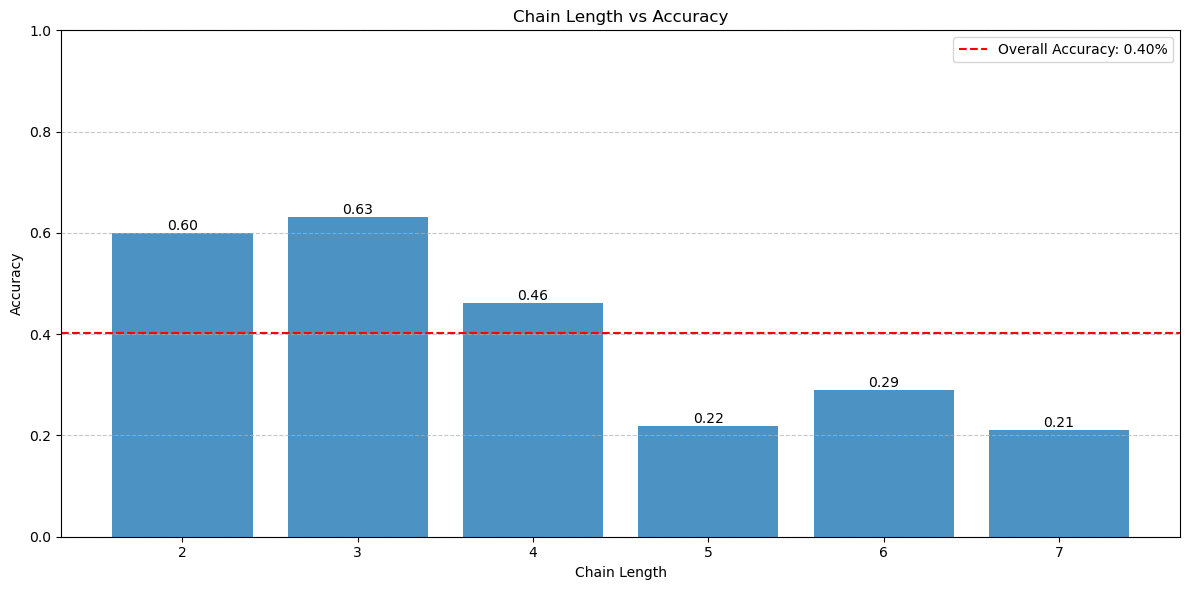

In [14]:
import re
m = ["output_lora_r128_a64_hops1-6/model_epoch_40.pt", "output_lora_r64_a32_hops1-6/model_epoch_40.pt", "output_lora_r32_a16_hops1-6/model_epoch_40.pt", "output_lora_r16_a8_hops1-6/model_epoch_40.pt"]


def extract_rank_alpha(model_path):
    # Using regex to extract rank and alpha values
    # Matches patterns like "r128_a64" or "r32_a16"
    match = re.search(r'r(\d+)_a(\d+)', model_path)
    if match:
        rank = int(match.group(1))
        alpha = int(match.group(2))
        return rank, alpha
    raise ValueError(f"Could not extract rank and alpha from path: {model_path}")


for i in m:
    # Load the trained model
    model_path = i
    model_name = "gpt2"

    # Load the pre-trained GPT-2 model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Load the state dict from the saved model
    state_dict = torch.load(model_path)

    rank, alpha = extract_rank_alpha(i)
    replace_with_lora_layers_last_n(model, n_layers_to_modify=12, rank=rank, alpha=alpha)

    # Load the state dict into the model
    model.load_state_dict(state_dict)

    model.model_path = model_path

    # Move the model to the appropriate device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    print(f"Loaded model from {model_path}")
    visualize_reasoning_hash_performance(model, tokenizer, num_tests=1000, hash_length=4, chains=[8,7,6,5,4,3,2], vary_hash=True, num_chains=4)

In [81]:
input_text = """Map:
bidr=>dp0w
dp0w=>orn8
bidr=>q94b
Start: bidr
Task: shortest path
Target: """

input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

# Create attention mask
attention_mask = torch.ones(input_ids.shape, dtype=torch.long).to(device)

with torch.no_grad():
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=10,
        num_return_sequences=1,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.0001
    )

completion = tokenizer.decode(output[0], skip_special_tokens=True)
print(completion)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Map:
bidr=>dp0w
dp0w=>orn8
bidr=>q94b
Start: bidr
Task: shortest path
Target: izp!!!!!!!!


In [24]:
def dummy_model_hop_performance(model_path, num_tests=40, hash_length=4, chain_length=10, hops=4):
    # Create a dummy model object
    class DummyConfig:
        model_path = model_path

    dummy_model = DummyConfig()

    dummy_model.model_path = model_path
    
    # Create a dummy tokenizer (we won't use it, but the function expects it)
    dummy_tokenizer = None

    # Call the original compare_hop_performance function
    compare_hop_performance(dummy_model, dummy_tokenizer, num_tests, hash_length, chain_length, hops)


Results cached to output_lora_r256_a128_hops1-6/model_epoch_40.pt_reasoning.log
Chain accuracies: {7: {'correct': 28, 'total': 166, 'accuracy': 0.1686746987951807}, 2: {'correct': 78, 'total': 148, 'accuracy': 0.527027027027027}, 5: {'correct': 54, 'total': 177, 'accuracy': 0.3050847457627119}, 3: {'correct': 105, 'total': 162, 'accuracy': 0.6481481481481481}, 4: {'correct': 74, 'total': 173, 'accuracy': 0.4277456647398844}, 6: {'correct': 24, 'total': 174, 'accuracy': 0.13793103448275862}}
Chains: [8, 7, 6, 5, 4, 3, 2]
Overall accuracy: 0.363
Plot saved to output_lora_r256_a128_hops1-6/model_epoch_40.pt_reasoning_plot_bar.png


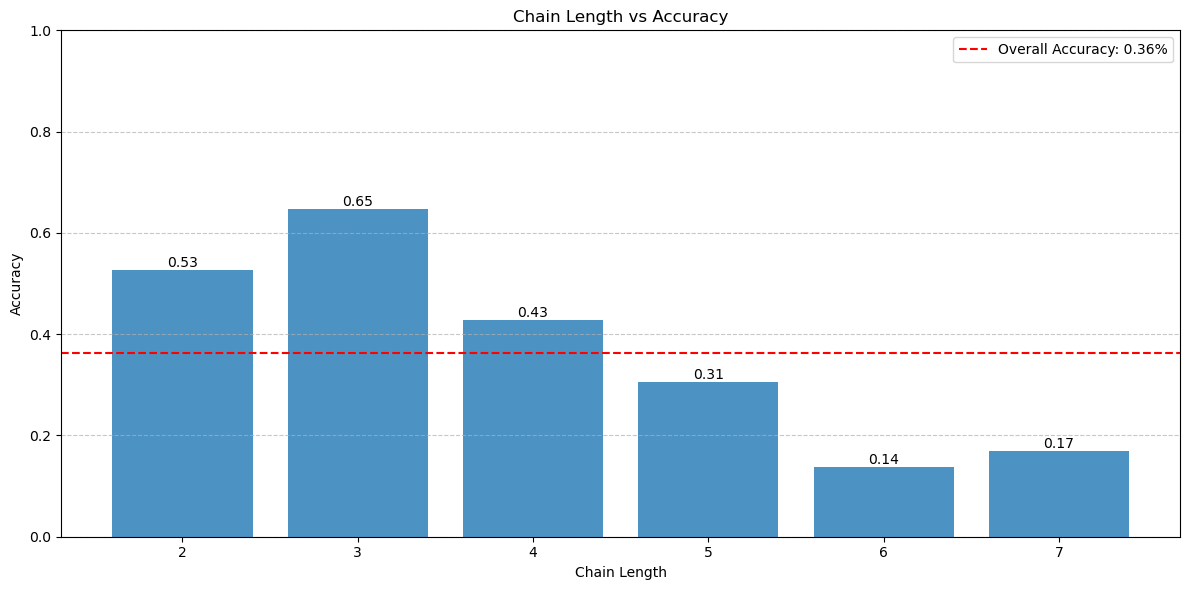

In [8]:
visualize_reasoning_hash_performance(model, tokenizer, num_tests=1000, hash_length=4, chains=[8,7,6,5,4,3,2], vary_hash=True, num_chains=4)

Cached results don't match current parameters. Running new tests.


Results cached to output_lora_r8_a4_hops1-6/model_epoch_40.pt_reasoning.log
Chain accuracies: {3: {'correct': 80, 'total': 147, 'accuracy': 0.54421768707483}, 7: {'correct': 39, 'total': 167, 'accuracy': 0.23353293413173654}, 5: {'correct': 50, 'total': 175, 'accuracy': 0.2857142857142857}, 4: {'correct': 58, 'total': 188, 'accuracy': 0.30851063829787234}, 6: {'correct': 49, 'total': 169, 'accuracy': 0.28994082840236685}, 2: {'correct': 122, 'total': 154, 'accuracy': 0.7922077922077922}}
Chains: [8, 7, 6, 5, 4, 3, 2]
Overall accuracy: 0.398
Plot saved to output_lora_r8_a4_hops1-6/model_epoch_40.pt_reasoning_plot_bar.png


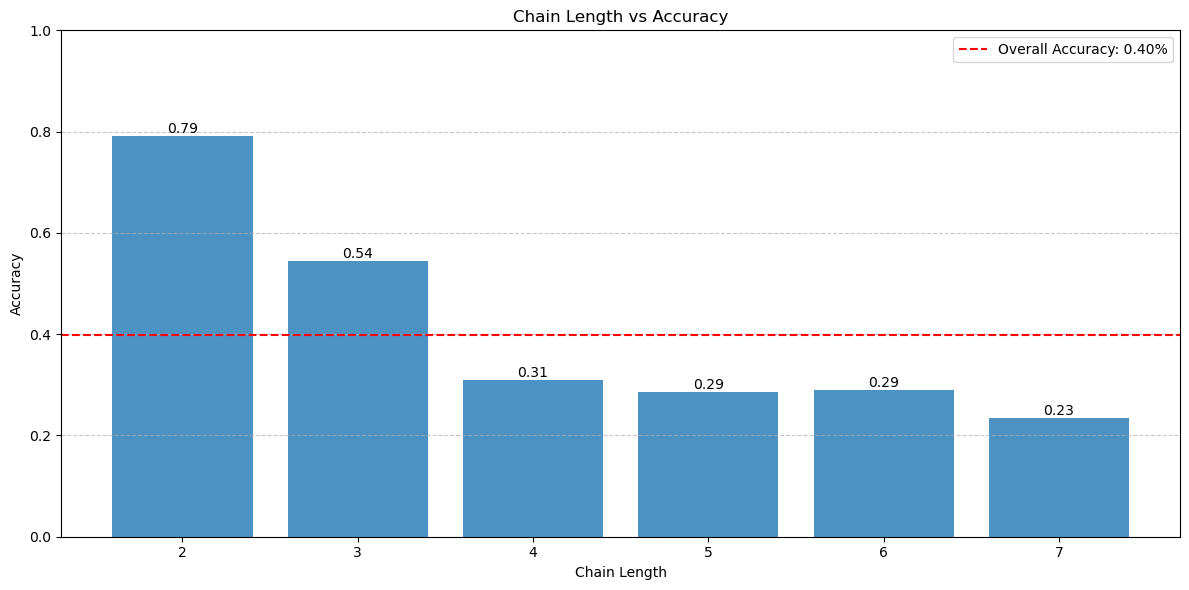

In [24]:
visualize_reasoning_hash_performance(model, tokenizer, num_tests=1000, hash_length=4, chains=[8,7,6,5,4,3,2], vary_hash=True, num_chains=3)

Loading cached results from base_reasoning_23456_3chain/model_epoch_40.pt_reasoning.log
Chain accuracies: {4: {'correct': 102, 'total': 167, 'accuracy': 0.6107784431137725}, 7: {'correct': 51, 'total': 179, 'accuracy': 0.2849162011173184}, 2: {'correct': 125, 'total': 167, 'accuracy': 0.7485029940119761}, 3: {'correct': 111, 'total': 165, 'accuracy': 0.6727272727272727}, 5: {'correct': 57, 'total': 152, 'accuracy': 0.375}, 6: {'correct': 46, 'total': 170, 'accuracy': 0.27058823529411763}}
Chains: [8, 7, 6, 5, 4, 3, 2]
Overall accuracy: 0.492
Plot saved to base_reasoning_23456_3chain/model_epoch_40.pt_reasoning_plot_bar.png


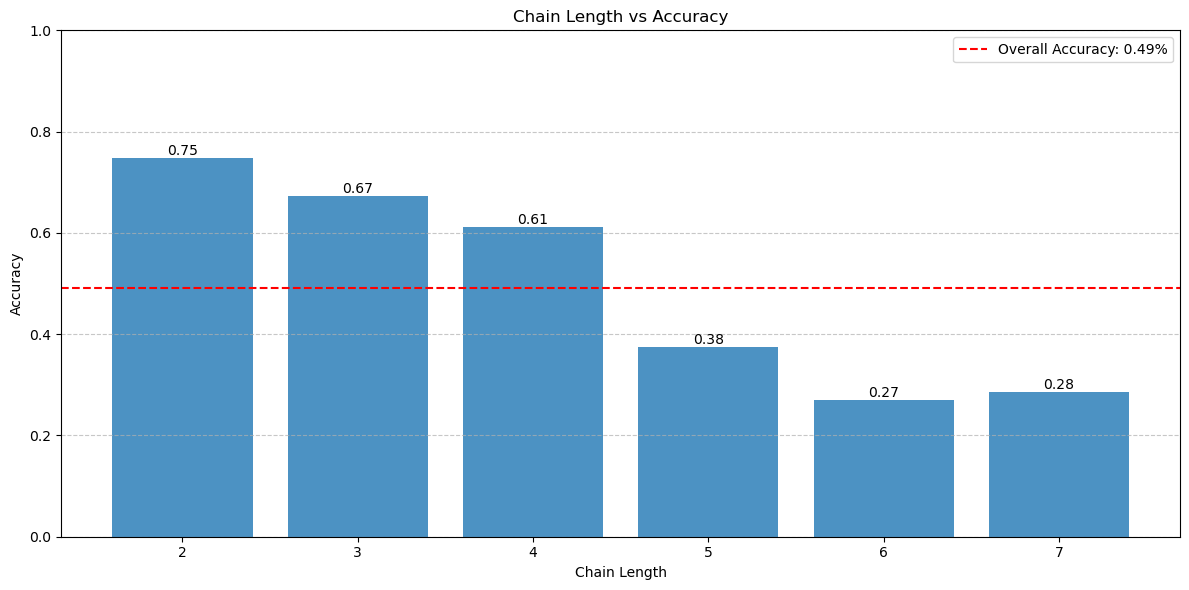

In [21]:
visualize_reasoning_hash_performance(model, tokenizer, num_tests=1000, hash_length=4, chains=[8,7,6,5,4,3,2], vary_hash=True, num_chains=3)

output_base_no_lora_15/model_epoch_40.pt.log
Cached results don't match current parameters. Running new tests.


Evaluating hop counts:   7%|▋         | 1/15 [00:35<08:18, 35.61s/it]

Accuracy for 1 hop(s): 0.83


Evaluating hop counts:  13%|█▎        | 2/15 [01:09<07:30, 34.65s/it]

Accuracy for 2 hop(s): 0.75


Evaluating hop counts:  20%|██        | 3/15 [01:42<06:47, 33.95s/it]

Accuracy for 3 hop(s): 0.69


Evaluating hop counts:  27%|██▋       | 4/15 [02:13<06:00, 32.74s/it]

Accuracy for 4 hop(s): 0.73


Evaluating hop counts:  33%|███▎      | 5/15 [02:44<05:21, 32.14s/it]

Accuracy for 5 hop(s): 0.45


Evaluating hop counts:  40%|████      | 6/15 [03:15<04:46, 31.85s/it]

Accuracy for 6 hop(s): 0.25


Evaluating hop counts:  47%|████▋     | 7/15 [03:47<04:14, 31.81s/it]

Accuracy for 7 hop(s): 0.07


Evaluating hop counts:  53%|█████▎    | 8/15 [04:19<03:42, 31.79s/it]

Accuracy for 8 hop(s): 0.06


Evaluating hop counts:  60%|██████    | 9/15 [04:53<03:14, 32.37s/it]

Accuracy for 9 hop(s): 0.04


Evaluating hop counts:  67%|██████▋   | 10/15 [05:25<02:42, 32.40s/it]

Accuracy for 10 hop(s): 0.07


Evaluating hop counts:  73%|███████▎  | 11/15 [05:56<02:08, 32.10s/it]

Accuracy for 11 hop(s): 0.06


Evaluating hop counts:  80%|████████  | 12/15 [06:28<01:35, 31.80s/it]

Accuracy for 12 hop(s): 0.03


Evaluating hop counts:  87%|████████▋ | 13/15 [06:59<01:03, 31.61s/it]

Accuracy for 13 hop(s): 0.06


Evaluating hop counts:  93%|█████████▎| 14/15 [07:30<00:31, 31.42s/it]

Accuracy for 14 hop(s): 0.07


Evaluating hop counts: 100%|██████████| 15/15 [08:01<00:00, 32.11s/it]


Accuracy for 15 hop(s): 0.05
Results cached to output_base_no_lora_15/model_epoch_40.pt.log


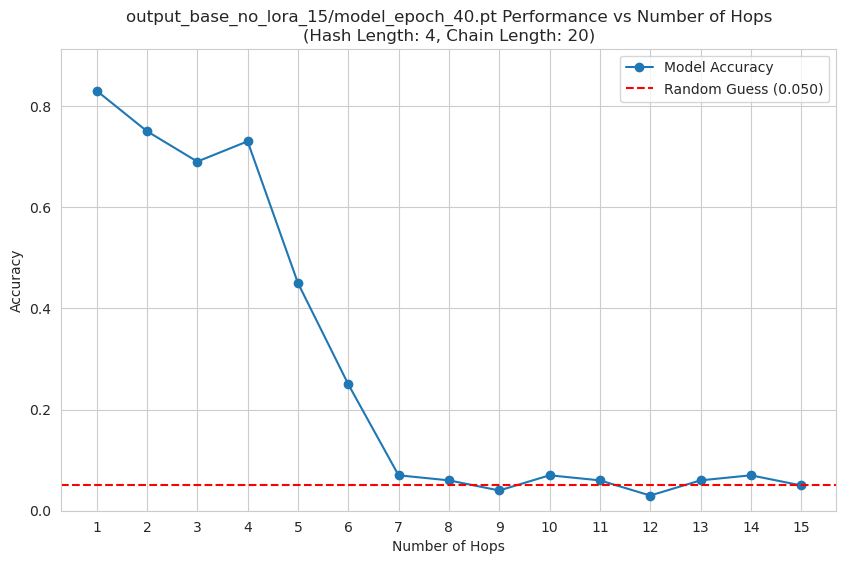

In [32]:
# Compare performance across different hop counts
compare_hop_performance(model, tokenizer, num_tests=100, hash_length=4, chain_length=20, hops=15)

output_base_no_lora_15/model_epoch_40.pt.log


Evaluating hop counts:   5%|▌         | 1/20 [00:32<10:23, 32.84s/it]

Accuracy for 1 hop(s): 0.84


Evaluating hop counts:  10%|█         | 2/20 [01:03<09:26, 31.48s/it]

Accuracy for 2 hop(s): 0.75


Evaluating hop counts:  15%|█▌        | 3/20 [01:33<08:45, 30.92s/it]

Accuracy for 3 hop(s): 0.74


Evaluating hop counts:  20%|██        | 4/20 [02:03<08:09, 30.56s/it]

Accuracy for 4 hop(s): 0.73


Evaluating hop counts:  25%|██▌       | 5/20 [02:34<07:40, 30.69s/it]

Accuracy for 5 hop(s): 0.37


Evaluating hop counts:  30%|███       | 6/20 [03:04<07:07, 30.50s/it]

Accuracy for 6 hop(s): 0.13


Evaluating hop counts:  35%|███▌      | 7/20 [03:35<06:36, 30.48s/it]

Accuracy for 7 hop(s): 0.05


Evaluating hop counts:  40%|████      | 8/20 [04:05<06:05, 30.42s/it]

Accuracy for 8 hop(s): 0.05


Evaluating hop counts:  45%|████▌     | 9/20 [04:36<05:36, 30.57s/it]

Accuracy for 9 hop(s): 0.07


Evaluating hop counts:  50%|█████     | 10/20 [05:07<05:06, 30.67s/it]

Accuracy for 10 hop(s): 0.03


Evaluating hop counts:  55%|█████▌    | 11/20 [05:39<04:39, 31.10s/it]

Accuracy for 11 hop(s): 0.07


Evaluating hop counts:  60%|██████    | 12/20 [06:09<04:06, 30.87s/it]

Accuracy for 12 hop(s): 0.06


Evaluating hop counts:  65%|██████▌   | 13/20 [06:39<03:34, 30.69s/it]

Accuracy for 13 hop(s): 0.09


Evaluating hop counts:  70%|███████   | 14/20 [07:11<03:05, 30.89s/it]

Accuracy for 14 hop(s): 0.05


Evaluating hop counts:  75%|███████▌  | 15/20 [07:42<02:34, 30.87s/it]

Accuracy for 15 hop(s): 0.10


Evaluating hop counts:  80%|████████  | 16/20 [08:11<02:02, 30.56s/it]

Accuracy for 16 hop(s): 0.08


Evaluating hop counts:  85%|████████▌ | 17/20 [08:43<01:32, 30.76s/it]

Accuracy for 17 hop(s): 0.04


Evaluating hop counts:  90%|█████████ | 18/20 [09:13<01:01, 30.78s/it]

Accuracy for 18 hop(s): 0.10


Evaluating hop counts:  95%|█████████▌| 19/20 [09:44<00:30, 30.63s/it]

Accuracy for 19 hop(s): 0.78


Evaluating hop counts: 100%|██████████| 20/20 [10:15<00:00, 30.76s/it]


Accuracy for 20 hop(s): 0.79
Results cached to output_base_no_lora_15/model_epoch_40.pt.log


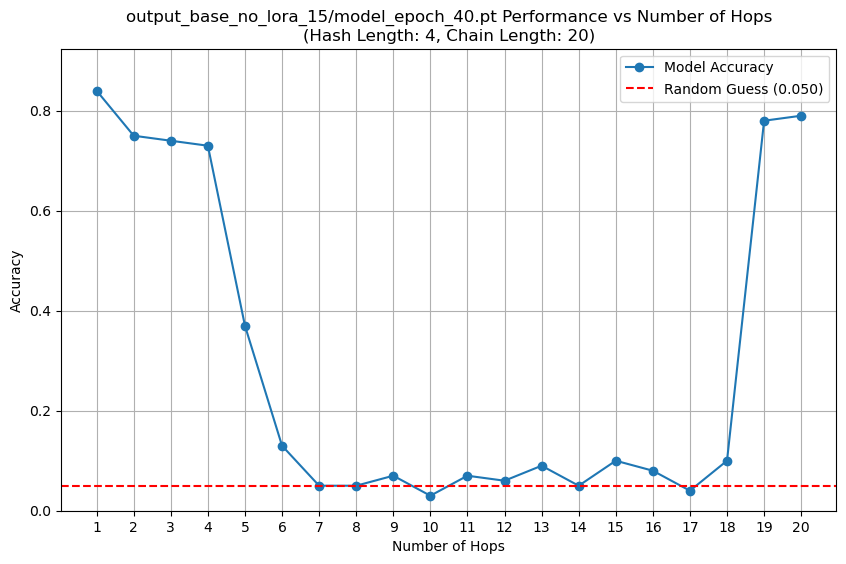

In [7]:
# Compare performance across different hop counts
compare_hop_performance(model, tokenizer, num_tests=100, hash_length=4, chain_length=20, hops=20)

hh_2vf/model_epoch_40.pt.log


Evaluating hop counts:  17%|█▋        | 1/6 [00:30<02:34, 30.92s/it]

Accuracy for 1 hop(s): 0.77


Evaluating hop counts:  33%|███▎      | 2/6 [01:03<02:06, 31.61s/it]

Accuracy for 2 hop(s): 0.26


Evaluating hop counts:  50%|█████     | 3/6 [01:36<01:37, 32.52s/it]

Accuracy for 3 hop(s): 0.07


Evaluating hop counts:  67%|██████▋   | 4/6 [02:08<01:04, 32.12s/it]

Accuracy for 4 hop(s): 0.04


Evaluating hop counts:  83%|████████▎ | 5/6 [02:39<00:31, 31.79s/it]

Accuracy for 5 hop(s): 0.05


Evaluating hop counts: 100%|██████████| 6/6 [03:11<00:00, 31.91s/it]


Accuracy for 6 hop(s): 0.04
Results cached to hh_2vf/model_epoch_40.pt.log


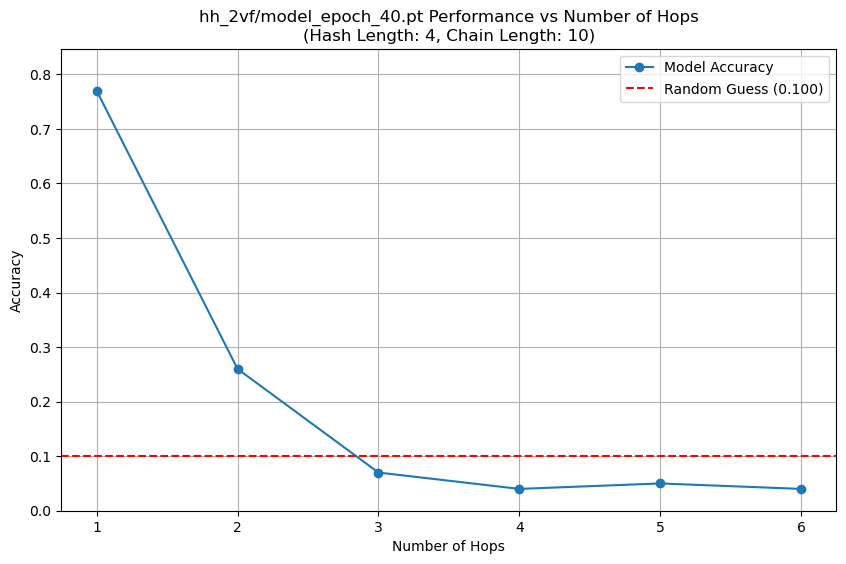

In [5]:
# Compare performance across different hop counts
compare_hop_performance(model, tokenizer, num_tests=100, hash_length=4, chain_length=10, hops=6)

hh_2v/model_epoch_40.pt.log


Evaluating hop counts:  17%|█▋        | 1/6 [00:31<02:39, 31.89s/it]

Accuracy for 1 hop(s): 0.71


Evaluating hop counts:  33%|███▎      | 2/6 [01:07<02:15, 33.89s/it]

Accuracy for 2 hop(s): 0.42


Evaluating hop counts:  50%|█████     | 3/6 [01:38<01:38, 32.83s/it]

Accuracy for 3 hop(s): 0.04


Evaluating hop counts:  67%|██████▋   | 4/6 [02:12<01:06, 33.30s/it]

Accuracy for 4 hop(s): 0.02


Evaluating hop counts:  83%|████████▎ | 5/6 [02:42<00:32, 32.19s/it]

Accuracy for 5 hop(s): 0.01


Evaluating hop counts: 100%|██████████| 6/6 [03:13<00:00, 32.30s/it]


Accuracy for 6 hop(s): 0.01
Results cached to hh_2v/model_epoch_40.pt.log


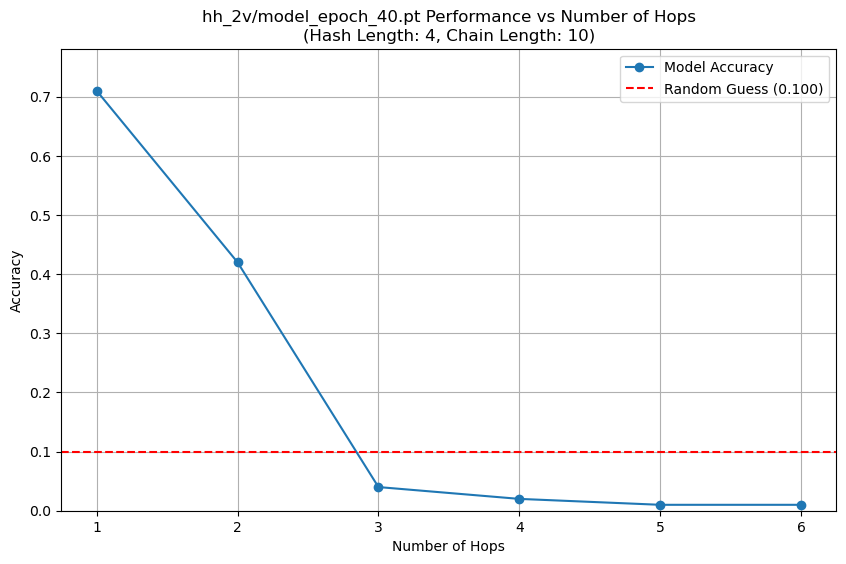

In [3]:
# Compare performance across different hop counts
compare_hop_performance(model, tokenizer, num_tests=100, hash_length=4, chain_length=10, hops=6)

hh_4v2_overfit/model_epoch_5.pt.log


Evaluating hop counts:  17%|█▋        | 1/6 [00:32<02:43, 32.74s/it]

Accuracy for 1 hop(s): 0.11


Evaluating hop counts:  33%|███▎      | 2/6 [01:05<02:10, 32.52s/it]

Accuracy for 2 hop(s): 0.08


Evaluating hop counts:  50%|█████     | 3/6 [01:37<01:36, 32.24s/it]

Accuracy for 3 hop(s): 0.07


Evaluating hop counts:  67%|██████▋   | 4/6 [02:07<01:02, 31.49s/it]

Accuracy for 4 hop(s): 0.07


Evaluating hop counts:  83%|████████▎ | 5/6 [02:37<00:31, 31.03s/it]

Accuracy for 5 hop(s): 0.05


Evaluating hop counts: 100%|██████████| 6/6 [03:08<00:00, 31.34s/it]


Accuracy for 6 hop(s): 0.05
Results cached to hh_4v2_overfit/model_epoch_5.pt.log


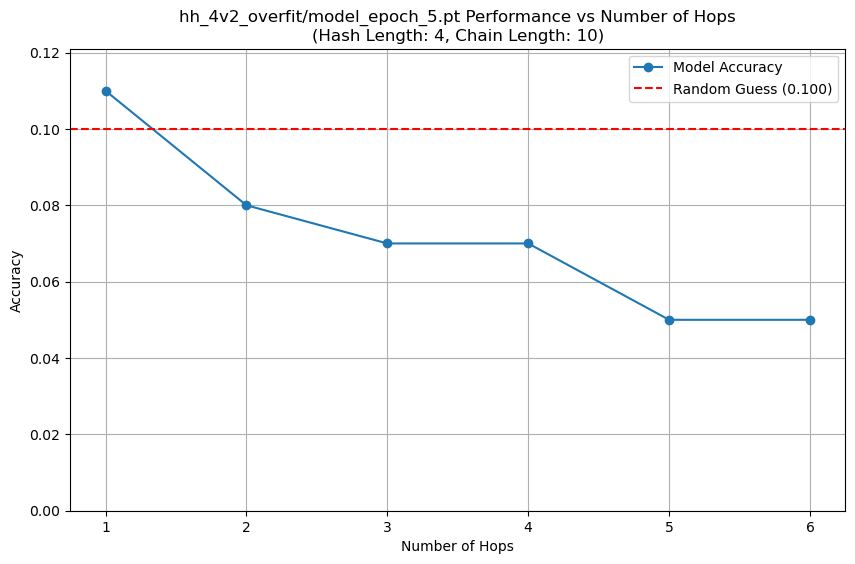

In [5]:
# Compare performance across different hop counts
compare_hop_performance(model, tokenizer, num_tests=100, hash_length=4, chain_length=10, hops=6)

base.log


Evaluating hop counts:  17%|█▋        | 1/6 [00:30<02:34, 30.95s/it]

Accuracy for 1 hop(s): 0.02


Evaluating hop counts:  33%|███▎      | 2/6 [01:01<02:01, 30.48s/it]

Accuracy for 2 hop(s): 0.03


Evaluating hop counts:  50%|█████     | 3/6 [01:31<01:31, 30.65s/it]

Accuracy for 3 hop(s): 0.00


Evaluating hop counts:  67%|██████▋   | 4/6 [02:03<01:01, 30.81s/it]

Accuracy for 4 hop(s): 0.01


Evaluating hop counts:  83%|████████▎ | 5/6 [02:33<00:30, 30.80s/it]

Accuracy for 5 hop(s): 0.02


Evaluating hop counts: 100%|██████████| 6/6 [03:05<00:00, 30.97s/it]


Accuracy for 6 hop(s): 0.03
Results cached to base.log


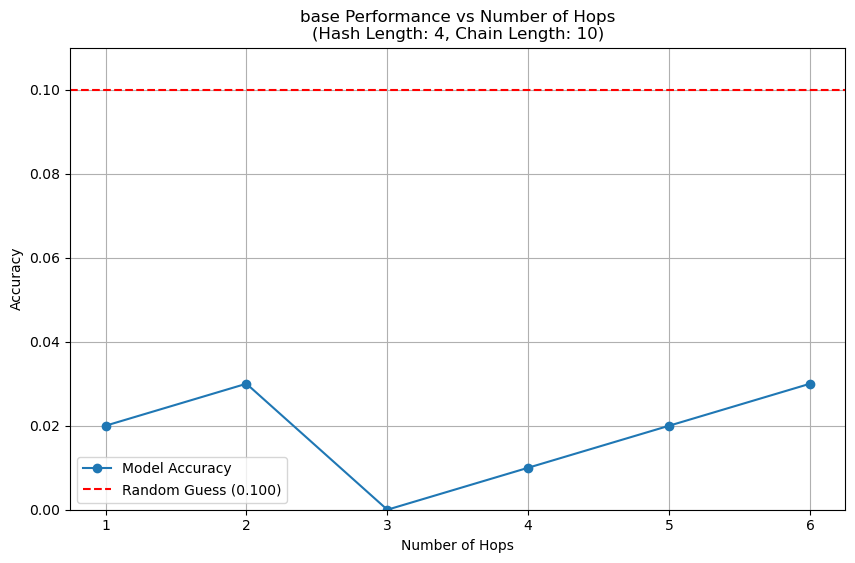

In [33]:
# Compare performance across different hop counts
compare_hop_performance(model, tokenizer, num_tests=100, hash_length=4, chain_length=10, hops=6)

Evaluating hop counts:  17%|█▋        | 1/6 [00:34<02:50, 34.13s/it]

Accuracy for 1 hop(s): 0.74


Evaluating hop counts:  33%|███▎      | 2/6 [01:04<02:08, 32.13s/it]

Accuracy for 2 hop(s): 0.15


Evaluating hop counts:  50%|█████     | 3/6 [01:37<01:37, 32.39s/it]

Accuracy for 3 hop(s): 0.08


Evaluating hop counts:  67%|██████▋   | 4/6 [02:08<01:03, 31.72s/it]

Accuracy for 4 hop(s): 0.08


Evaluating hop counts:  83%|████████▎ | 5/6 [02:40<00:31, 31.82s/it]

Accuracy for 5 hop(s): 0.13


Evaluating hop counts: 100%|██████████| 6/6 [03:11<00:00, 31.86s/it]


Accuracy for 6 hop(s): 0.06
Results cached to hh_4v2_overfit/model_epoch_40.pt.log


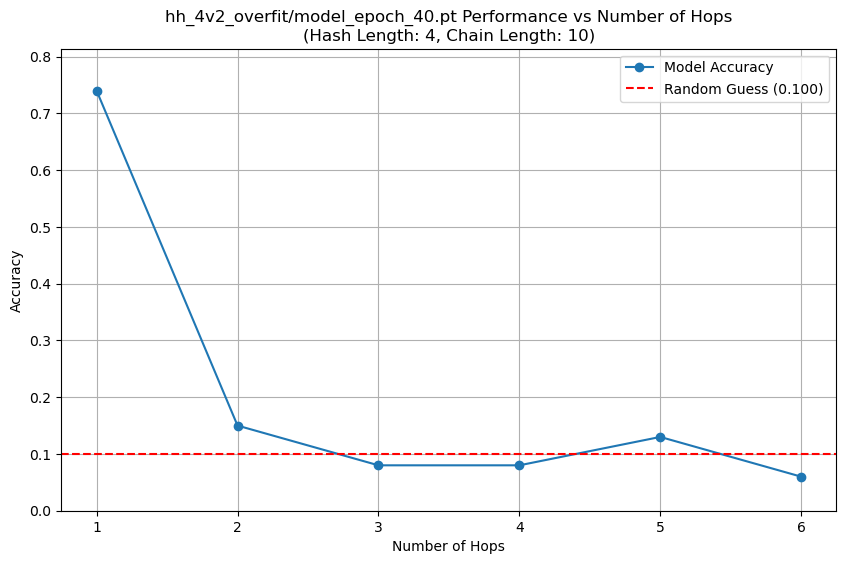

In [7]:
# Compare performance across different hop counts
compare_hop_performance(model, tokenizer, num_tests=100, hash_length=4, chain_length=10, hops=6)

hh_4v2/model_epoch_12.pt.log


Evaluating hop counts:  17%|█▋        | 1/6 [00:31<02:36, 31.29s/it]

Accuracy for 1 hop(s): 0.76


Evaluating hop counts:  33%|███▎      | 2/6 [01:01<02:03, 30.89s/it]

Accuracy for 2 hop(s): 0.13


Evaluating hop counts:  50%|█████     | 3/6 [01:33<01:33, 31.19s/it]

Accuracy for 3 hop(s): 0.11


Evaluating hop counts:  67%|██████▋   | 4/6 [02:06<01:04, 32.03s/it]

Accuracy for 4 hop(s): 0.12


Evaluating hop counts:  83%|████████▎ | 5/6 [02:36<00:31, 31.23s/it]

Accuracy for 5 hop(s): 0.07


Evaluating hop counts: 100%|██████████| 6/6 [03:08<00:00, 31.49s/it]

Accuracy for 6 hop(s): 0.15
Results cached to hh_4v2/model_epoch_12.pt.log


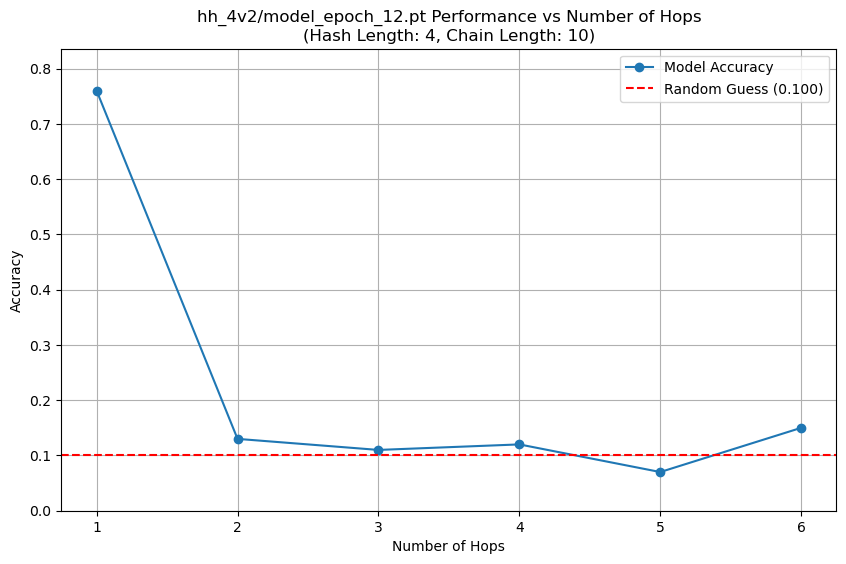

In [30]:
# Compare performance across different hop counts
compare_hop_performance(model, tokenizer, num_tests=100, hash_length=4, chain_length=10, hops=6)

Evaluating hop counts:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating hop counts:  17%|█▋        | 1/6 [00:31<02:39, 31.91s/it]

Accuracy for 1 hop(s): 0.72


Evaluating hop counts:  33%|███▎      | 2/6 [01:03<02:06, 31.60s/it]

Accuracy for 2 hop(s): 0.26


Evaluating hop counts:  50%|█████     | 3/6 [01:35<01:35, 31.82s/it]

Accuracy for 3 hop(s): 0.09


Evaluating hop counts:  67%|██████▋   | 4/6 [02:10<01:06, 33.08s/it]

Accuracy for 4 hop(s): 0.15


Evaluating hop counts:  83%|████████▎ | 5/6 [02:44<00:33, 33.59s/it]

Accuracy for 5 hop(s): 0.14


Evaluating hop counts: 100%|██████████| 6/6 [03:21<00:00, 33.50s/it]


Accuracy for 6 hop(s): 0.09
Results cached to hh_4v/model_epoch_12.pt.log


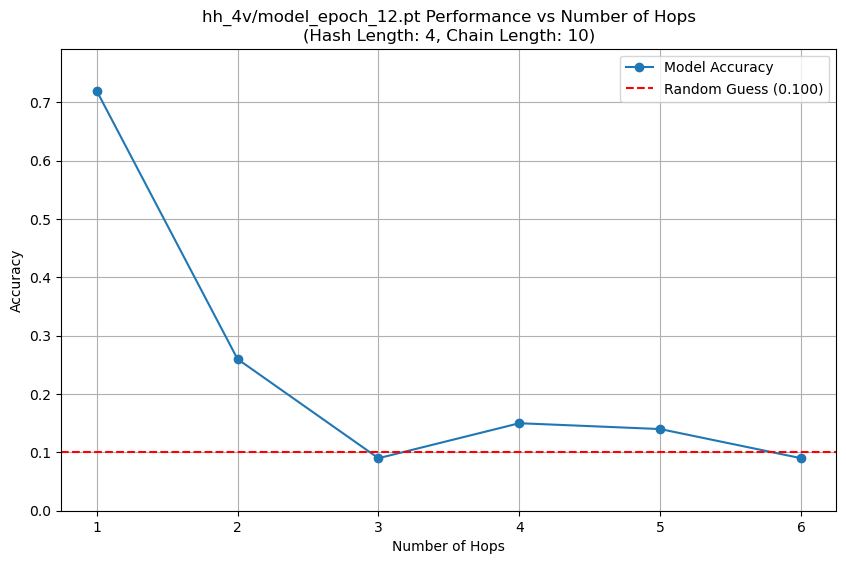

In [26]:
# Compare performance across different hop counts
compare_hop_performance(model, tokenizer, num_tests=100, hash_length=4, chain_length=10, hops=6)

In [27]:
%pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


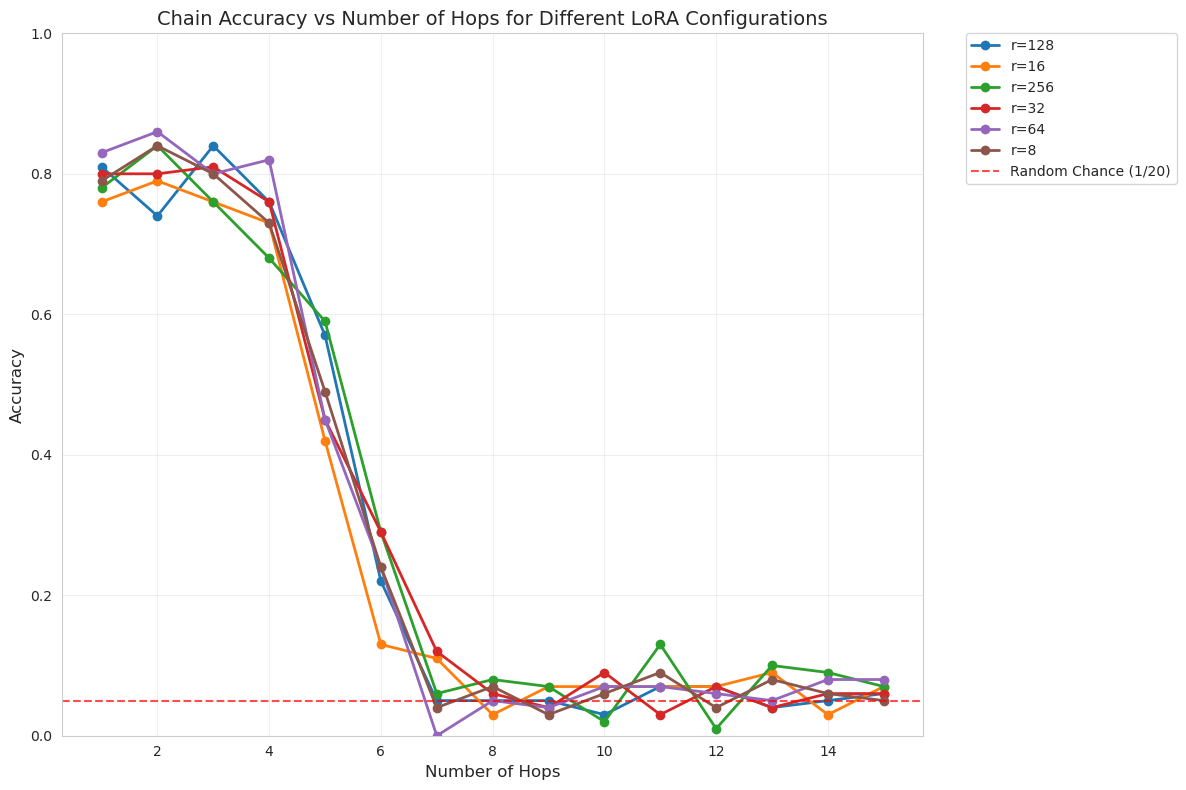


Summary Statistics:
--------------------------------------------------

r=128:
Mean accuracy: 0.294
Max accuracy: 0.840
Min accuracy: 0.030

r=16:
Mean accuracy: 0.280
Max accuracy: 0.790
Min accuracy: 0.030

r=256:
Mean accuracy: 0.305
Max accuracy: 0.840
Min accuracy: 0.010

r=32:
Mean accuracy: 0.299
Max accuracy: 0.810
Min accuracy: 0.030

r=64:
Mean accuracy: 0.300
Max accuracy: 0.860
Min accuracy: 0.000

r=8:
Mean accuracy: 0.294
Max accuracy: 0.840
Min accuracy: 0.030


In [29]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Read all log files
log_files = glob.glob('output_lora_r*_a*_hops1-6/model_epoch_40.pt.log')

# Extract configurations and data
configs = []
accuracies = []

for file in sorted(log_files):
    # Extract LoRA rank from filename
    rank = int(file.split('_r')[1].split('_')[0])
    
    # Read and parse log file
    with open(file, 'r') as f:
        data = json.load(f)
        accuracies.append(data['accuracies'])
        configs.append(f'r={rank}')

# Convert to numpy array for easier manipulation
accuracies = np.array(accuracies)

# Create the plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot lines for each configuration
for i, config in enumerate(configs):
    plt.plot(range(1, 16), accuracies[i], marker='o', label=config, linewidth=2, markersize=6)

# Add random chance line at 1/20
plt.axhline(y=1/20, color='red', linestyle='--', label='Random Chance (1/20)', alpha=0.7)

plt.xlabel('Number of Hops', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Chain Accuracy vs Number of Hops for Different LoRA Configurations', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, alpha=0.3)

# Set y-axis limits
plt.ylim(0, 1)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("-" * 50)
for i, config in enumerate(configs):
    print(f"\n{config}:")
    print(f"Mean accuracy: {np.mean(accuracies[i]):.3f}")
    print(f"Max accuracy: {np.max(accuracies[i]):.3f}")
    print(f"Min accuracy: {np.min(accuracies[i]):.3f}")

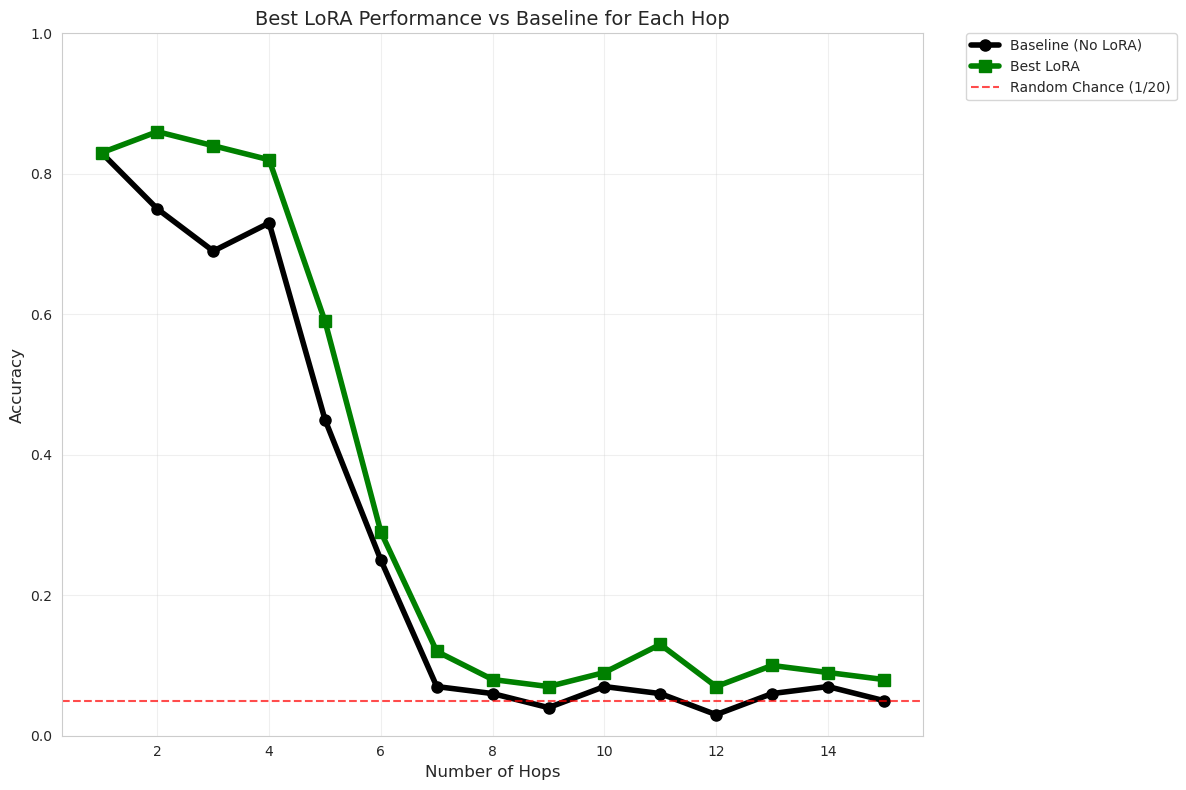


Detailed Comparison at Each Hop:
--------------------------------------------------
Hop | Baseline | Best LoRA |    Delta | Best Config
-----------------------------------------------------------------
  1 |    0.830 |    0.830 |   +0.000 | r=64
  2 |    0.750 |    0.860 |   +0.110 | r=64
  3 |    0.690 |    0.840 |   +0.150 | r=128
  4 |    0.730 |    0.820 |   +0.090 | r=64
  5 |    0.450 |    0.590 |   +0.140 | r=256
  6 |    0.250 |    0.290 |   +0.040 | r=256
  7 |    0.070 |    0.120 |   +0.050 | r=32
  8 |    0.060 |    0.080 |   +0.020 | r=256
  9 |    0.040 |    0.070 |   +0.030 | r=16
 10 |    0.070 |    0.090 |   +0.020 | r=32
 11 |    0.060 |    0.130 |   +0.070 | r=256
 12 |    0.030 |    0.070 |   +0.040 | r=128
 13 |    0.060 |    0.100 |   +0.040 | r=256
 14 |    0.070 |    0.090 |   +0.020 | r=256
 15 |    0.050 |    0.080 |   +0.030 | r=64

Summary Statistics:
--------------------------------------------------
Average Baseline Accuracy: 0.281
Average Best LoRA Accura

In [34]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Read baseline model log
with open('output_base_no_lora_15/model_epoch_40.pt.log', 'r') as f:
    baseline_data = json.load(f)
    baseline_accuracies = baseline_data['accuracies']

# Read all LoRA log files
log_files = glob.glob('output_lora_r*_a*_hops1-6/model_epoch_40.pt.log')

# Extract configurations and data
configs = []
accuracies = []

for file in sorted(log_files):
    # Extract LoRA rank from filename
    rank = int(file.split('_r')[1].split('_')[0])
    
    # Read and parse log file
    with open(file, 'r') as f:
        data = json.load(f)
        accuracies.append(data['accuracies'])
        configs.append(f'r={rank}')

# Convert to numpy array for easier manipulation
accuracies = np.array(accuracies)

# Find best LoRA performance for each hop
best_lora_accuracies = np.max(accuracies, axis=0)
best_lora_configs = np.argmax(accuracies, axis=0)

# Create the plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot baseline
plt.plot(range(1, 16), baseline_accuracies, marker='o', label='Baseline (No LoRA)', 
         linewidth=4, markersize=8, color='black')

# Plot best LoRA performance
plt.plot(range(1, 16), best_lora_accuracies, marker='s', label='Best LoRA', 
         linewidth=4, markersize=8, color='green')

# Add random chance line at 1/20
plt.axhline(y=1/20, color='red', linestyle='--', label='Random Chance (1/20)', alpha=0.7)

plt.xlabel('Number of Hops', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Best LoRA Performance vs Baseline for Each Hop', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, alpha=0.3)

# Set y-axis limits
plt.ylim(0, 1)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

# Print detailed comparison
print("\nDetailed Comparison at Each Hop:")
print("-" * 50)
print(f"{'Hop':>3} | {'Baseline':>8} | {'Best LoRA':>8} | {'Delta':>8} | {'Best Config'}")
print("-" * 65)
for hop in range(15):
    baseline = baseline_accuracies[hop]
    best_lora = best_lora_accuracies[hop]
    delta = best_lora - baseline
    best_config = configs[best_lora_configs[hop]]
    print(f"{hop+1:3d} | {baseline:8.3f} | {best_lora:8.3f} | {delta:+8.3f} | {best_config}")

# Print summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print(f"Average Baseline Accuracy: {np.mean(baseline_accuracies):.3f}")
print(f"Average Best LoRA Accuracy: {np.mean(best_lora_accuracies):.3f}")
print(f"Maximum Baseline Accuracy: {np.max(baseline_accuracies):.3f}")
print(f"Maximum Best LoRA Accuracy: {np.max(best_lora_accuracies):.3f}")
print(f"Average Improvement: {np.mean(best_lora_accuracies - baseline_accuracies):.3f}")